In [361]:
import tensorflow.compat.v1 as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, concatenate, Input, Embedding
from tensorflow.keras.layers import Reshape, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
import numpy as np
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [362]:
def one_hot(df, cols):
  """Returns one-hot encoding of DataFrame df including columns in cols."""
  for col in cols:
    dummies = pd.get_dummies(df[col], prefix=col, drop_first=False)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(col, axis=1)
  return df


## Load data

In [363]:
df = pd.read_csv('data/adult.data')
df.columns = ['age', 'workclass', 'weight', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

elvis = [25, 'Private', 27821, 'Bachelors', 17, 'Married-civ-spouse', 'Other-service', 'Husband', 'Asian-Pac-Islander', 'Male', 1000, 2000, 40, 'China', '<=50K']

#Shuffle
df = df.sample(frac=1)

# Add our test data
df = df.append(pd.Series(elvis, index=df.columns ), ignore_index=True)

elvis_df = df.iloc[-1]



In [364]:
# Remove occupation from df as it's our label, then create a mapping of labels
actions = df['occupation'].astype('category').cat.codes #.to_numpy()
action_space = df['occupation'].astype('category').cat.categories
actions_mapping = dict(enumerate(df['occupation'].astype('category').cat.categories))

df = df.drop(['occupation'], axis = 1)
df = one_hot(df, ['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'native-country', 'income'])

# Setup rewards and drop income column
rewards = df['income_ >50K']
df = df.drop(['income_ >50K', 'income_ <=50K'], axis = 1)

In [365]:
## scikit-learn scaler object to scale the states
scaler = StandardScaler()
scaler.fit(df)
df = scaler.transform(df)

## Trian test split

In [366]:
n_data, state_size = df.shape
n_train = n_data // 3 * 2
train_data = df[:n_train]
test_data = df[n_train:]

print("total data size: {}".format(df.shape))
print("training data size: {}".format(train_data.shape))
print("test data size: {}".format(test_data.shape))

total data size: (32561, 101)
training data size: (21706, 101)
test data size: (10855, 101)


### Defining our neural network used by the agent

In [367]:
def build_model(state_size, action_size):
    # shared layer
    model = Sequential([
        Input(shape=(state_size,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(action_size, activation='relu')])
    
    # compiling
    model.compile(loss='mse', optimizer='adam')
    
    # returning the model
    return model


## Define agent

Here the contextual bandit problem is a simplified version of a full RL problem, where the beginning state is the previous state of a terminal state. Therefore we can simplify the following Bellman's equation
![alt text](https://miro.medium.com/max/5032/1*CiDCpUjj_3mGm3vdGrxu4g.png)

into just 
```
V(s)=max(R(s,a))
```
as terminal states have value of 0



In [397]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.model = build_model(state_size, action_size)
        self.loss = []
    
    def act(self, state):
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action
    
    def learn(self, states, actions, rewards):
        # Calculate the tentative target: Q(s',a)
        target = rewards

        # With the Keras API, the target (usually) must have the same
        # shape as the predictions.
        # However, we only need to update the network for the actions
        # which were actually taken.
        # We can accomplish this by setting the target to be equal to
        # the prediction for all values.
        # Then, only change the targets for the actions taken.
        # Q(s,a)
        target_full = self.model.predict(states)
        target_full[np.arange(states.shape[0]), actions] = target

        # Run one training step
        res = self.model.train_on_batch(states, target_full)
        self.loss.append(res)

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

(21706, 101)
(32561,)
(32561,)
training 50/339
training 100/339
training 150/339
training 200/339
training 250/339
training 300/339


Text(0, 0.5, 'Loss (mse)')

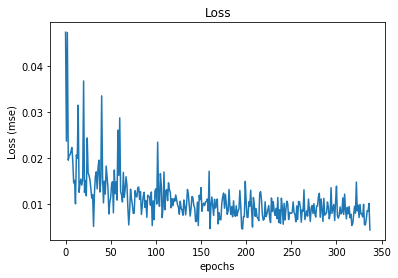

In [403]:
agent = DQNAgent(state_size, action_space.shape[0])

print(train_data.shape)
print(actions.shape)
print(rewards.shape)

# print(rewards[:10].toNumpy())
BATCH_SIZE = 64
for i in range(1, n_train//BATCH_SIZE):
    if(i%50 == 0):
        print("training {}/{}".format(i, n_train // BATCH_SIZE))
        
    agent.learn(train_data[(i - 1) * BATCH_SIZE : BATCH_SIZE * i], 
                actions[(i - 1) * BATCH_SIZE : BATCH_SIZE * i], 
                rewards[(i - 1) * BATCH_SIZE : BATCH_SIZE * i])

    
plt.plot(agent.loss)
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("Loss (mse)")

In [404]:
print(elvis_df)

age                               25
workclass                    Private
weight                         27821
education                  Bachelors
education-num                     17
marital-status    Married-civ-spouse
occupation             Other-service
relationship                 Husband
race              Asian-Pac-Islander
sex                             Male
capital-gain                    1000
capital-loss                    2000
hours-per-week                    40
native-country                 China
income                         <=50K
Name: 32560, dtype: object


In [408]:
act_values = agent.model.predict(df[-2:-1])
print("This is the agent's recommendation:")
print(action_space[np.argmax(act_values)])

This is the agent's recommendation:
 Exec-managerial


In [391]:
## Compare with baseline algorithm

[[0.         0.         0.20960677 0.01630005 0.         0.07403892
  0.         0.         0.         0.06116757 0.02084612 0.
  0.         0.15443206 0.31636682 0.        ]]
 Transport-moving
